<a href="https://colab.research.google.com/github/JestinG20/customer-church-prediction/blob/main/customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score, roc_curve)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. Load Dataset
train = pd.read_csv('customer_train.csv')
test = pd.read_csv('customer_test.csv')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (440833, 12)
Test Shape: (64374, 12)


In [7]:
# 3. Data Cleaning
# Check for missing values
print(train.isnull().sum())

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


In [8]:
# For simplicity, fill missing numeric with median, categorical with mode
for col in train.columns:
    if train[col].dtype == 'object':
        train[col].fillna(train[col].mode()[0], inplace=True)
        test[col].fillna(test[col].mode()[0], inplace=True)
    else:
        train[col].fillna(train[col].median(), inplace=True)
        test[col].fillna(test[col].median(), inplace=True)

In [9]:
# Encoding Gender before Bivariate Analysis
train['Gender'] = train['Gender'].map({'Male': 1, 'Female': 0})
test['Gender'] = test['Gender'].map({'Male': 1, 'Female': 0})

# Encode Subscription Type
train['Subscription Type'] = train['Subscription Type'].map({'Basic': 0, 'Standard': 1, 'Premium': 2})
test['Subscription Type'] = test['Subscription Type'].map({'Basic': 0, 'Standard': 1, 'Premium': 2})

# Encode Contract Length
train['Contract Length'] = train['Contract Length'].map({'Monthly': 1, 'Quarterly': 3, 'Annual': 12})
test['Contract Length'] = test['Contract Length'].map({'Monthly': 1, 'Quarterly': 3, 'Annual': 12})

In [10]:
# 6. Encoding Categorical Variables
cat_cols = ['Gender', 'Subscription Type', 'Contract Length']
le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [11]:
# 4. EDA
# Univariate Analysis
train.describe()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
count,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000,440833.000000
mean,225398.669604,39.373153,0.567682,31.256337,15.807494,3.604435,12.965719,1.012821,1.204374,631.616289,14.480867,0.567108
std,129531.771637,12.442355,0.495399,17.255708,8.586232,3.070215,8.258053,0.813356,0.746851,240.802732,8.596198,0.495477
min,2.000000,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113622.000000,29.000000,0.000000,16.000000,9.000000,1.000000,6.000000,0.000000,1.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,1.000000,32.000000,16.000000,3.000000,12.000000,1.000000,1.000000,661.000000,14.000000,1.000000
75%,337739.000000,48.000000,1.000000,46.000000,23.000000,6.000000,19.000000,2.000000,2.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,1.000000,60.000000,30.000000,10.000000,30.000000,2.000000,2.000000,1000.000000,30.000000,1.000000


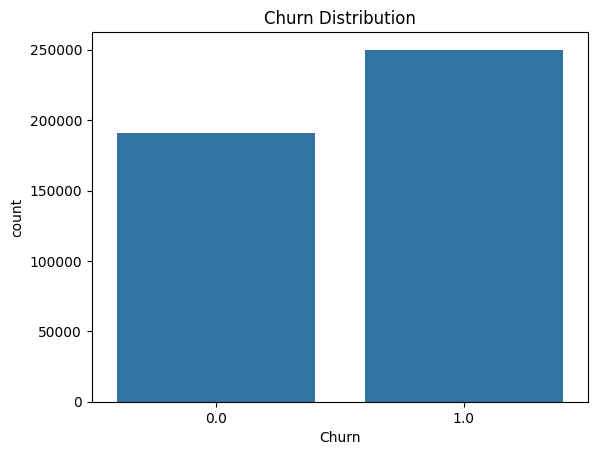

In [12]:
# Churn distribution
sns.countplot(data=train, x='Churn')
plt.title('Churn Distribution')
plt.show()

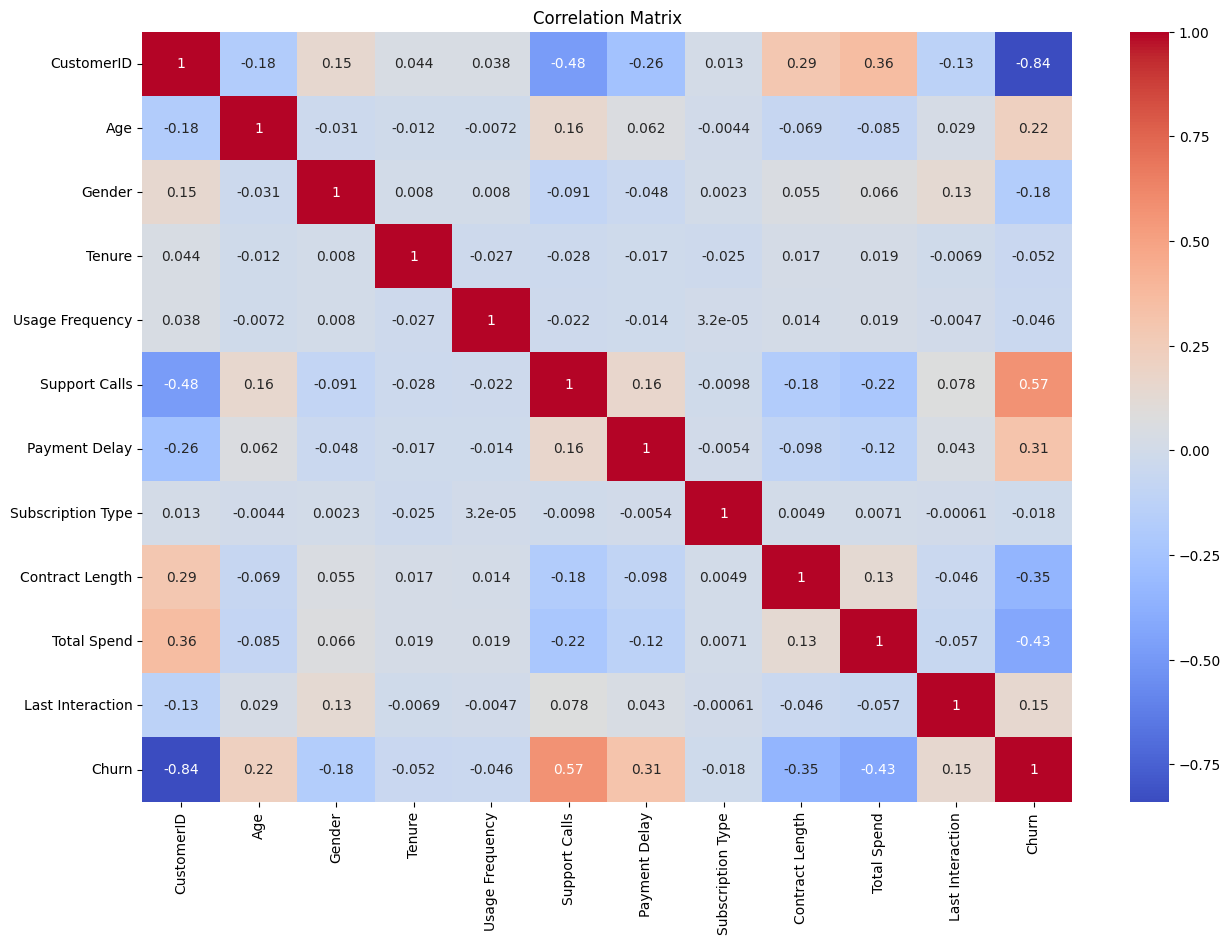

In [13]:
# Bivariate Analysis
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

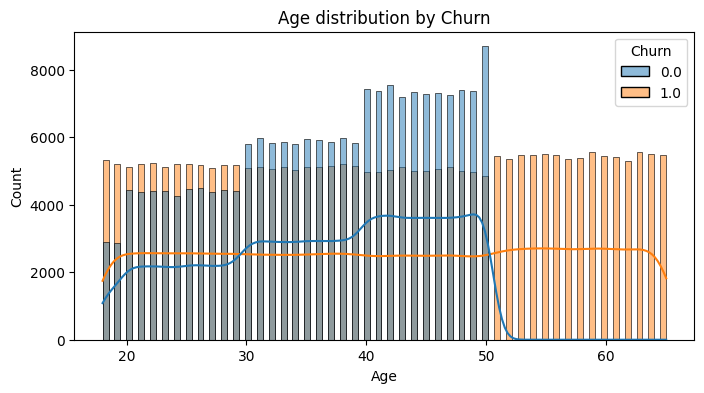

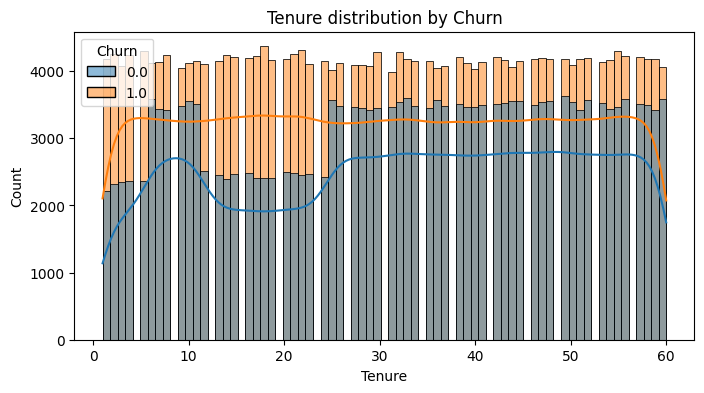

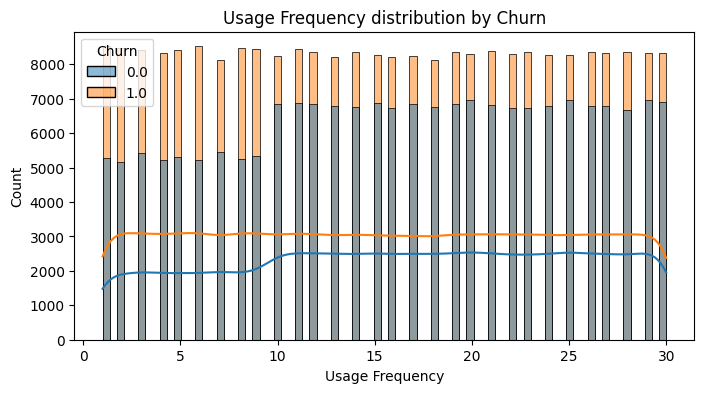

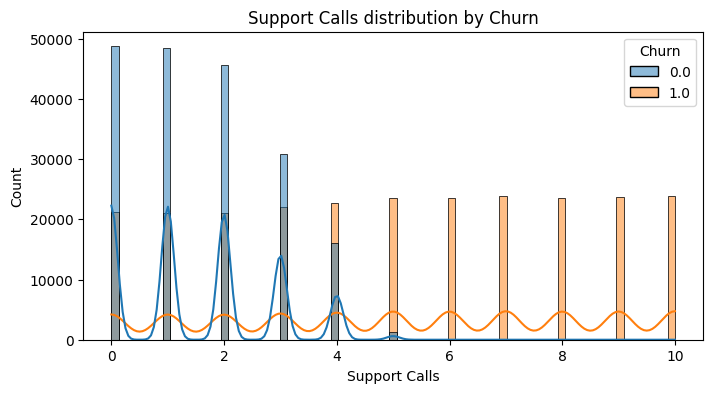

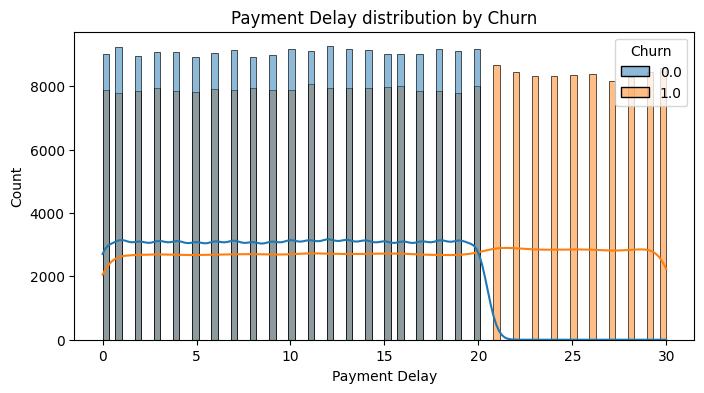

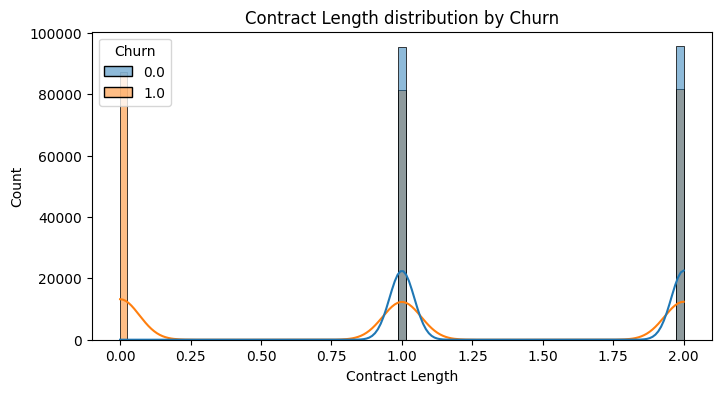

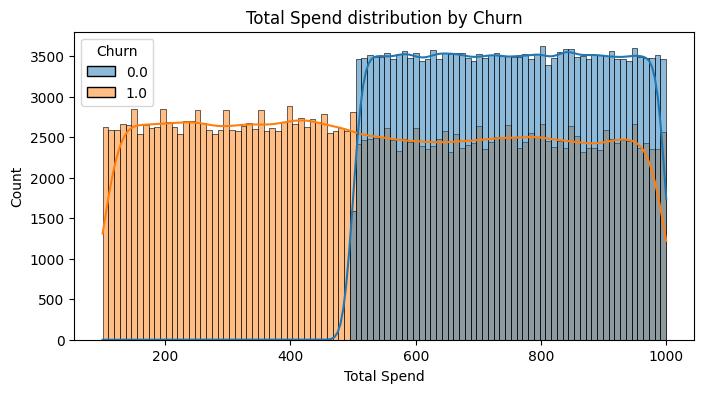

In [14]:
# Churn vs Numeric Features
num_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Contract Length', 'Total Spend']
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(data=train, x=col, hue='Churn', kde=True)
    plt.title(f'{col} distribution by Churn')
    plt.show()

In [15]:
# 5. Feature Engineering
# Create New Features
train['Spend_per_month'] = train['Total Spend'] / (train['Tenure'] + 1)
test['Spend_per_month'] = test['Total Spend'] / (test['Tenure'] + 1)

train['Interaction_recency'] = pd.to_datetime('today') - pd.to_datetime(train['Last Interaction'])
test['Interaction_recency'] = pd.to_datetime('today') - pd.to_datetime(test['Last Interaction'])

train['Interaction_recency_days'] = train['Interaction_recency'].dt.days
test['Interaction_recency_days'] = test['Interaction_recency'].dt.days

train.drop(['Interaction_recency', 'Last Interaction'], axis=1, inplace=True)
test.drop(['Interaction_recency', 'Last Interaction'], axis=1, inplace=True)

In [16]:
# 7. Feature Selection
X = train.drop(['CustomerID', 'Churn'], axis=1)
y = train['Churn']

In [17]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Mutual Information
selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(X_scaled, y)
selected_features = X.columns[selector.get_support()]

print("Selected Features:", list(selected_features))

Selected Features: ['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Spend_per_month']


In [19]:
# 8. Final Train/Test Split
X = train[selected_features]
X_test = test[selected_features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# 9. Modeling
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    results[name] = {
        'Accuracy': accuracy_score(y_val, preds),
        'Precision': precision_score(y_val, preds),
        'Recall': recall_score(y_val, preds),
        'F1': f1_score(y_val, preds),
        'ROC_AUC': roc_auc_score(y_val, preds)
    }

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199976, number of negative: 152690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 352666, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567041 -> initscore=0.269788
[LightGBM] [Info] Start training from score 0.269788


In [21]:
# 10. Simple Neural Network
model_nn = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_nn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[early_stop], batch_size=32, verbose=0)

nn_preds = model_nn.predict(X_val)
nn_preds_binary = (nn_preds > 0.5).astype(int)

results['Neural Network'] = {
    'Accuracy': accuracy_score(y_val, nn_preds_binary),
    'Precision': precision_score(y_val, nn_preds_binary),
    'Recall': recall_score(y_val, nn_preds_binary),
    'F1': f1_score(y_val, nn_preds_binary),
    'ROC_AUC': roc_auc_score(y_val, nn_preds)
}

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [22]:
# 11. Evaluation
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Precision    Recall        F1   ROC_AUC
Logistic Regression  0.862772   0.892282  0.862226  0.876996  0.862857
Random Forest        0.991096   0.999959  0.984348  0.992092  0.992148
XGBoost              0.991006   0.999980  0.984168  0.992011  0.992071
LightGBM             0.990779   0.999837  0.983908  0.991809  0.991849
CatBoost             0.991074   1.000000  0.984268  0.992071  0.992134
Neural Network       0.940216   0.999487  0.895090  0.944412  0.981695


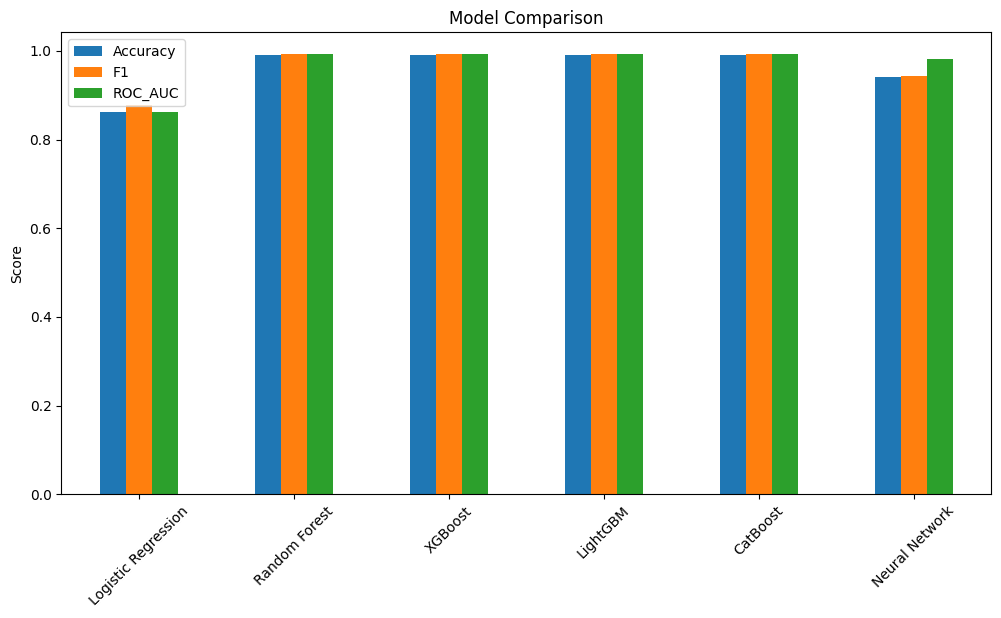

In [23]:
# Plot comparison
results_df[['Accuracy', 'F1', 'ROC_AUC']].plot(kind='bar', figsize=(12,6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

In [24]:
# 12. Conclusion
# - Report best performing model based on ROC AUC and F1 score
best_model = results_df.sort_values('ROC_AUC', ascending=False).iloc[0]
print("\nBest Model Based on ROC AUC:\n", best_model)


Best Model Based on ROC AUC:
 Accuracy     0.991096
Precision    0.999959
Recall       0.984348
F1           0.992092
ROC_AUC      0.992148
Name: Random Forest, dtype: float64
